In [46]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

# Pandas data processing

## Combine data.csv files into a single dataframe

## Cleanup
 - Throwaway keys irrelevant for the figures and do renaming

In [47]:
# map of keys to their renamings
rename = {
    'avg_latency': 'latency',
}
# keys to keep
include = ['dsp', 'lut', 'latency']

def cleanup(df):
    # rename
    for k, v in rename.items():
        df.loc[df['key'] == k, 'key'] = v

    # only keep things in include
    return df[df['key'].isin(include)].reset_index(drop=True)

# polybench data
standard_hls = pd.read_csv("../results/standard/hls/data.csv")
standard_futil = pd.read_csv("../results/standard/futil/data.csv")
standard_futil_lat = pd.read_csv("../results/standard/futil-latency/data.csv")
unrolled_hls = pd.read_csv("../results/unrolled/hls/data.csv")
unrolled_futil = pd.read_csv("../results/unrolled/futil/data.csv")
unrolled_futil_lat = pd.read_csv("../results/unrolled/futil-latency/data.csv")
polybench_raw = standard_hls.append(standard_futil).append(standard_futil_lat).append(unrolled_hls).append(unrolled_futil).append(unrolled_futil_lat).reset_index(drop=True)
polybench = cleanup(polybench_raw)

# systolic data
hls = pd.read_csv("../results/systolic/hls/data.csv")
futil = pd.read_csv("../results/systolic/futil/data.csv")
futil_lat = pd.read_csv("../results/systolic/futil-latency/data.csv")
systolic_raw = hls.append(futil).append(futil_lat).reset_index(drop=True)
systolic = cleanup(systolic_raw)

## Calculate norms 

In [48]:
def match(df, benchmark, typ):
    return df[(df['benchmark'] == benchmark) & (df['type'] == typ)]

def norm(df, top_key, bot_key, name):
    df = df.copy()
    for bench in df['benchmark'].unique():
        norm = match(df, bench, top_key).copy()
        norm['value'] = match(df, bench, top_key)['value'].values / match(df, bench, bot_key)['value'].values
        norm['type'] = name
        df = df.append(norm)
    return df
        
polybench = norm(polybench, 'futil', 'hls', 'norm')
polybench = norm(polybench, 'futil-unrolled', 'hls-unrolled', 'norm-unrolled')

## Dataframe formatting
 - Transition from long-form to short-form data by using `pivot`.
 - Reorder table so that unrolled benchmarks are grouped at the beginning

In [49]:
def pivot_and_order(df, order):
    df = df.pivot(index=['benchmark', 'type'], columns='key', values='value').reset_index()
    df['benchmark'] = pd.Categorical(df['benchmark'], order)
    return df

polybench = pivot_and_order(polybench, [
    '2mm', 
    '3mm', 
    'atax',
    'doitgen',
    'gemm',
    'gemver',
    'gesummv',
    'gramschmidt',
    'mvt',
    'syr2k', 
    'syrk',
    'bicg',
    'cholesky',
    'durbin',
    'lu',
    'ludcmp',
    'symm',
    'trisolv', 
    'trmm'
])

systolic = pivot_and_order(systolic, [
    'gemm_2', 
    'gemm_4',
    'gemm_6',
    'gemm_8'
])

# Graph Generation

## 5a. Systolic Array Normalized cycle counts

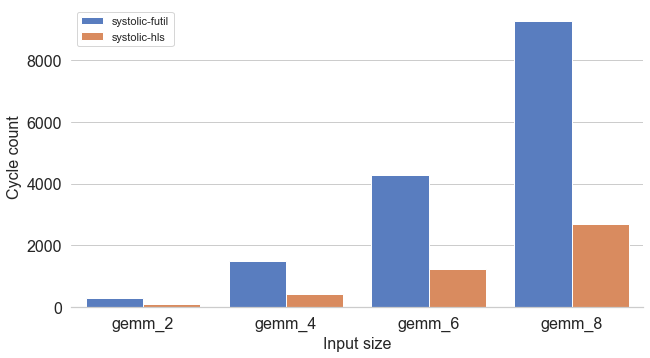

In [56]:
g = sns.catplot(
    x="benchmark", 
    y="latency", 
    hue="type", 
    data=systolic,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Cycle count", fontsize=16)
g.set_xlabels("Input size", fontsize=16)
g.set_yticklabels(fontsize=16)
g.set_xticklabels(fontsize=16)
g.axes[0,0].legend(loc='upper left',).set_title('')
g.fig.set_size_inches(10,5)

## 5b. Systolic Array Normalized LUT usage

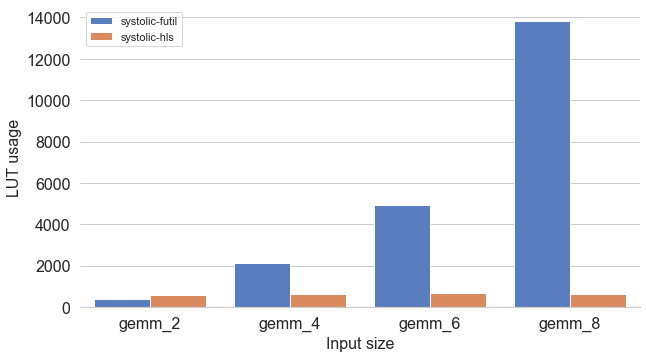

In [58]:
g = sns.catplot(
    x="benchmark", 
    y="lut", 
    hue="type", 
    data=systolic,
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("LUT usage", fontsize=16)
g.set_xlabels("Input size", fontsize=16)
g.set_yticklabels(fontsize=16)
g.set_xticklabels(fontsize=16)
g.axes[0,0].legend(loc='upper left',).set_title('')
g.fig.set_size_inches(10,5)

## 6a. Cycle counts normalized to Vivado HLS

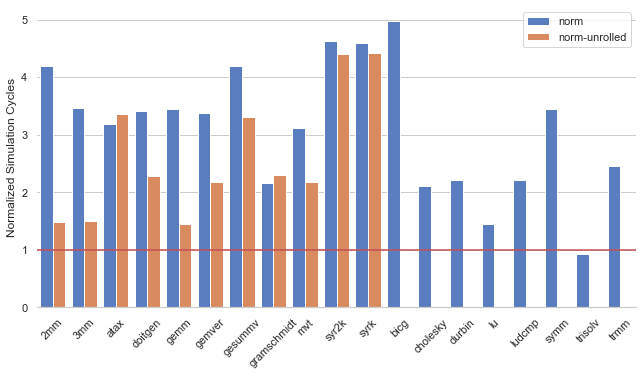

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

g = sns.catplot(
    x="benchmark",
    y="latency",
    hue="type",
    data=df[df['type'].isin(['norm', 'norm-unrolled'])],
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Simulation Cycles")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
# g.savefig('log-norm-lat.pdf')

## 6b. LUT usage normalized to Vivado HLS

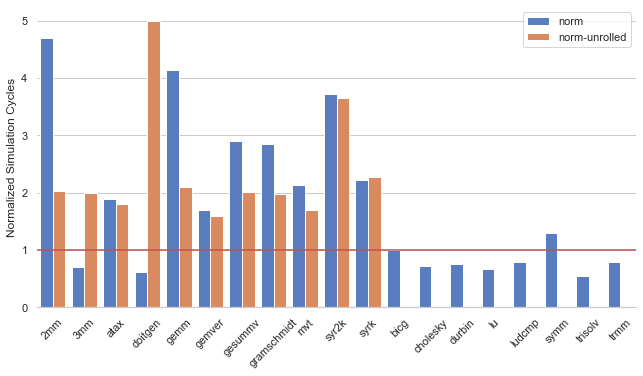

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

g = sns.catplot(
    x="benchmark",
    y="lut",
    hue="type",
    data=df[df['type'].isin(['norm', 'norm-unrolled'])],
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Simulation Cycles")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
# g.savefig('log-norm-lat.pdf')

## 6c. Cycle counts normalized to latency-insensitive design 

In [10]:
# todo: